# グローバーのアルゴリズム: 実装例
$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\def\braket#1#2{\mathinner{\left\langle{#1}\middle|#2\right\rangle}}
$$

In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

In [2]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))], abs(state.get_vector()))
    plt.show()

## 動作の確認
5qubitでグローバーのアルゴリズムを実装し、動作の確認をする。
規定の数が32個

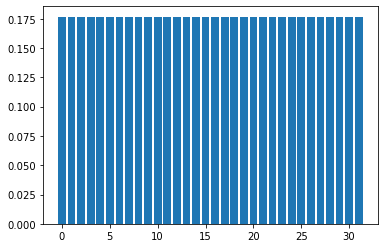

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state,nqubits)

オラクル$U_w$を作る。今回は、$ \ket{1...1} $を解として設定し、$\ket{1...1}$飲みに位相(-1)をつける演算子を作る。

In [4]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits - 1))
    # i - th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits - 1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

オラクルの作用が確認すると、確かに最後の成分だけ、位相が反転していることがわかる。

In [5]:
_ = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(_)
print(_.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


同様に、$\ket{s}$を対象軸にした反転$U_s$を作る。以下の式が成り立つことを使う。

In [6]:
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    # 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    # 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

それでは、$U_sU_w$を1回だけ作用させて確率分布の変化を見る。

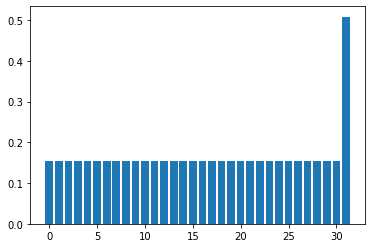

In [7]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

これを何回か繰り返す    

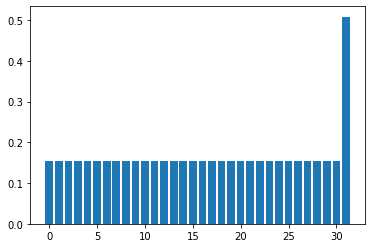

0.5082329989778305


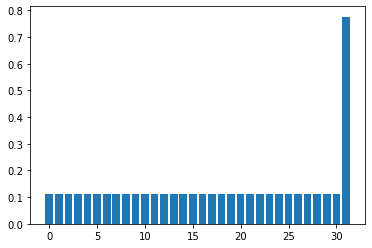

0.7761601777867947


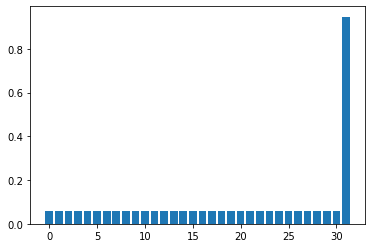

0.9470673343724091


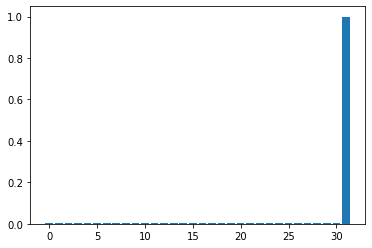

0.9995910741614723


In [8]:
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1)

# グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state, nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

$k = 4$回ほどでの繰り返しで、ほぼ確率1で解の状態を得ることができた。

次に、`nqubits`を大きくして、kに対する解出力確率の振る舞いをチェックする

maximal probability 9.997306e-01 is obtained at k = 25


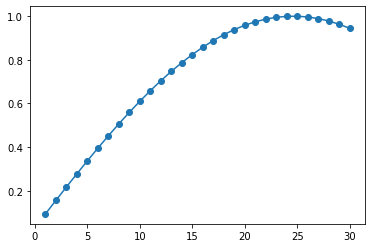

In [9]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits - 1)

# グローバーのアルゴリズムの実行
Hadamard = make_Hadamard(nqubits)
U_w = make_U_w(nqubits)
U_s = make_U_s(nqubits)

result = []

state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    # show_distribution(state, nqubits)
    result.append(np.linalg.norm(inner_product(state, target_state)))

max_k = np.argmax(result)
print(f"maximal probability {result[max_k]:5e} is obtained at k = {max_k+1}")

plt.plot(np.arange(1, 30+1), result, "o-")

$k = 25$回でほぼ確率1でtarget状態が得られていることがわかる。

また、確率のk依存性は、$\sin$関数になっていることもわかる。
Q本当にsin関数なのか？

最後に、解を見つけるのに必要なkが量子ビット数についてどのように振る舞うかを見てみる。

In [10]:
result = []
min_nqubits = 6
max_nqubits = 16
for nqubits in range(min_nqubits, max_nqubits+1, 2):
    ## 回路の準備
    Hadamard = make_Hadamard(nqubits)
    U_w= make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    ## 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)

    ## 確率が減少を始めるまで U_s U_w をかける
    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 and num_iter <= 1000:
        num_iter += 1
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else:
            flag = 1
    result.append( [nqubits, num_iter, suc_prob] )
    print(f"nqubits={nqubits}, num_iter={num_iter}, suc_prob={suc_prob:5e}")

nqubits=6, num_iter=7, suc_prob=9.526013e-01
nqubits=8, num_iter=13, suc_prob=9.930691e-01
nqubits=10, num_iter=26, suc_prob=9.963280e-01
nqubits=12, num_iter=51, suc_prob=9.992534e-01
nqubits=14, num_iter=101, suc_prob=9.998851e-01
nqubits=16, num_iter=202, suc_prob=9.999368e-01


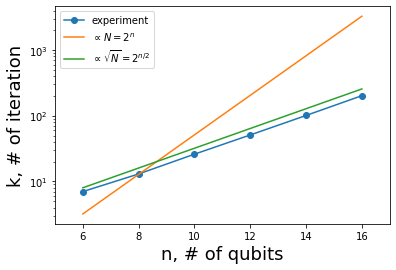

In [11]:
result_array = np.array(result)

plt.xlim(min_nqubits-1, max_nqubits+1)
plt.xlabel("n, # of qubits", fontsize = 18)
plt.ylabel("k, # of iteration", fontsize = 18)
plt.semilogy(result_array[:, 0], result_array[:, 1], "-o", label = "experiment")
plt.semilogy(result_array[:,0], 0.05*2**result_array[:,0], "-", label=r"$\propto N=2^n$")
plt.semilogy(result_array[:,0], 2**(0.5*result_array[:,0]), "-", label=r"$\propto \sqrt{N}=2^{n/2}$")
plt.legend(fontsize = 10)

このことから、計算量が $O(N)$ではなく、$O(\sqrt{N})$であることがわかる。